### Patrick Horlaville (260931235) - Problem Set 2 - PHYS 512 : Computational Physics with Applications

Prof: Jon Sievers. TAs: Marcus Merryfield, Rigel Zifkin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

## Problem 1

First we set up the equation for the electric field equation, as shown in the PDF document. We also set up our parameters and variables: R, the shell radius, $\sigma$, the surface charge density and z, our range of distances as our function input

In [2]:
R = 1.0
sigma = 1
eps = 1
z = np.linspace(0, 20, 1001)
npts = len(z)

In [3]:
def efield_int_arg(theta, z, R, sigma, eps):

    const = (R**2)*sigma/2/eps
    int_arg = ((z - R*np.cos(theta))*np.sin(theta))/((R**2 + z**2 - 2*R*z*np.cos(theta))**(3/2))
    
    return const*int_arg

We would like to integrate this function. To build our integrator, we make use of some code snippets from class

In [4]:
def integrate_adaptive(efield_int_arg, theta0, theta1, z, prec):
    
    theta = np.linspace(theta0, theta1, 5) 
    e = efield_int_arg(theta, z, R, sigma, eps)
    
    dtheta = (theta1 - theta0)/(len(theta) - 1)

    area1 = 2*dtheta*(e[0] + 4*e[2] + e[4])/3
    area2 = dtheta*(e[0] + 4*e[1] + 2*e[2] + 4*e[3] + e[4])/3

    error = np.abs(area1 - area2)

    if error < prec:
        return area2

    else: 
        theta_mid = (theta0 + theta1)/2
        left = integrate_adaptive(efield_int_arg, theta0, theta_mid, z, prec/2)
        right = integrate_adaptive(efield_int_arg, theta_mid, theta1, z, prec/2)
        return left + right

Now we can compute the integral with our integrator and compare with the results from the quad function. We use a precision tolerance of 10^(-7) to avoid the blow up at z = R for our integrator function.

In [5]:
E_integrator = np.zeros(len(z))
E_quad = np.zeros(len(z))

prec = 1e-7

for i in range(len(z)):
 
    def inst(theta):
        return efield_int_arg(theta, z[i], R, sigma, eps)
    
    E_quad_t = integrate.quad(inst, 0, np.pi)
    E_quad[i] = E_quad_t[0]
    
    if z[i] == R:
        continue
    
    E_i = integrate_adaptive(efield_int_arg, 0, np.pi, z[i], prec)
    E_integrator[i] = E_i

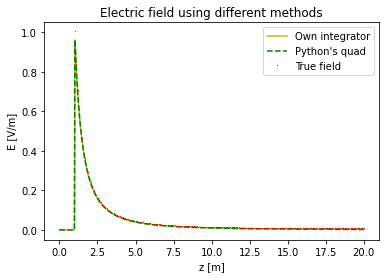

In [36]:
z_true = np.linspace(R, 20, 200)
E_true = 1/z_true**2

plt.plot(z, E_integrator, 'y', label = 'Own integrator')
plt.plot(z, E_quad, '--g', label = "Python's quad")
plt.plot(z_true, E_true, ',r', label = 'True field')
plt.title('Electric field using different methods')
plt.xlabel('z [m]')
plt.ylabel('E [V/m]')
plt.legend()
plt.show()

## Problem 2

First, we write our integrator. It is divided in two parts: the first one, where 'extra' is None, calculates the initial set of points and areas. The number of function calls is equivalent to the length of the array of points we are using to perform our integration initially. If the error (i.e., the difference between the finer and coarser calculations for our integral) is too big (i.e., bigger than our tolerance), then we split the operation in 2 (in terms of the x domain), and we add the two contributions together (a process that may be iterative if the error is still too big after the split). For following steps, new function calls are only needed if the function has not already been called before. For comparison we compute also the number of calls that would have required an integrator that does not perform this way. That way, at the end of our integration, we can compare the number of calls that were used by our integrator to what the integrator made in class would have computed.

In [43]:
def integrate_adaptive(fun, a, b, tol, extra = None):

    if type(extra) == type(None): 
        
        global new_count
        global lazy_count
        
        x = np.linspace(a, b, 5)
        y = fun(x)
        
        dx = (b - a)/(len(x) - 1)
        area1 = 2*dx*(y[0] + 4*y[2] + y[4])/3 
        area2 = dx*(y[0] + 4*y[1] + 2*y[2] + 4*y[3] + y[4])/3 
        err = np.abs(area1 - area2)
        
        data = np.vstack((x,y)) 

        new_count = len(x)
        lazy_count = len(x)

        
        if err < tol: 
            
            return area2, new_count, lazy_count

        else: 
            
            left = integrate_adaptive(fun, a, (a + b)/2, tol/2, extra = data)[0] 
            right = integrate_adaptive(fun, (a + b)/2, b, tol/2, extra = data)[0] 
            
            return left + right
    
    else: 
        
        data = extra
        x_data = data[0] 
        y_data = data[1]

        x = np.linspace(a, b, 5)
        y = np.empty(len(x))

        
        for i, x_i in enumerate(x):
            
            if x_i in x_data: 
                
                index = np.where(x_data == x_i)[0][0] 
                y[i] = y_data[index]
            
            else:
                
                x_data = np.append(x_data, x_i) 
                y[i] = fun(x_i) 
                y_data = np.append(y_data, y[i]) 
                new_count += 1 
            
        
        lazy_count += len(x) 

        data = np.vstack((x_data, y_data)) 
        
        dx = (b - a)/(len(x) - 1)
        area1 = 2*dx*(y[0] + 4*y[2] + y[4])/3 
        area2 = dx*(y[0] + 4*y[1] + 2*y[2] + 4*y[3] + y[4])/3
        err = np.abs(area1 - area2)
        
        if err < tol: 
            
            return area2, 
        
        else:
            
            midpoint = (a + b)/2
            left = integrate_adaptive(fun, a, midpoint, tol/2, extra = data)
            right = integrate_adaptive(fun, midpoint, b, tol/2, extra = data)

            return left + right

Now we can check how many calculations are saved through our new integrator. We can try it out on integrating for example the exponential and normal functions

In [61]:
def expp(x):
    return np.exp(x)

In [64]:
def gauss(x):
    return np.exp(-(x**2))

We call our variables for the new and lazy counts. They are global and are to be resetted for different integrations

In [84]:
new_count = 0 
lazy_count = 0

integral_exp = integrate_adaptive(expp, 0, 1, 1e-7)
new_exp = new_count
lazy_exp = lazy_count

In [85]:
print('For the exponential function integrated from 0 to 1, we now have', new_exp, 'function calls instead of', lazy_exp)
print('The computed integral value is', integral_exp)

For the exponential function integrated from 0 to 1, we now have 57 function calls instead of 135
The computed integral value is 0.2394818400675705


In [86]:
new_count = 0 
lazy_count = 0

integral_gauss = integrate_adaptive(gauss, -10, 10, 1e-7)
new_gauss = new_count
lazy_gauss = lazy_count

In [88]:
print('For the unit gaussian function integrated from -10 to 10, we now have', new_gauss, 'function calls instead of', lazy_gauss)
print('The computed integral value is', integral_gauss)

For the unit gaussian function integrated from -10 to 10, we now have 785 function calls instead of 1955
The computed integral value is 0.019528766763852002


## Problem 3

In [89]:
from numpy.polynomial.chebyshev import chebfit, chebval

Here we make the function that fits the log2 function over the (0.5, 1) interval over n points. We first rescale the x interval, perform the Chebyshev fit up to an arbitrary order and truncate the coefficients below the tolerance level. The function gives the coefficients and the amount of deleted coefficients from the truncation.

In [93]:
def log2_fit(n, order, tol):

    x = np.linspace(0.5, 1, n) 
    y = np.log2(x)
    
    x_scale = 4*x - 3
    
    coef = chebfit(x_scale, y, order)
    
    coef[np.abs(coef) <= tol] = 0 
    len_del_coef = len(np.where(coef == 0)[0])
    
    return coef, len_del_coef

In [140]:
n = 20
order = 20
tol = 1e-6

coefs, len_del_coefs = log2_fit(n, order, tol)

In [141]:
print('We truncated', len_del_coefs, 'coefficients from the', len(coefs), 'initial ones with our example')

We truncated 6 coefficients from the 21 initial ones with our example


Now, we want to compute the log base e of any number. We first find the mantissa and exponent decomposition of said number. We compute the Chebyshev coefficients of our log 2 fit from our previous function. We scale then the mantissa according to the scaling. We can find the log base 2 of the mantissa from our Chebyshev coefficients, which we can combine with the exponent from the decomposition to find the log base e of x according to the formula as found in the PDF. 

In [129]:
def mylog2(x, n, order, tol):

    M, exp = np.frexp(x) 

    coef = log2_fit(n, order, tol) 
    
    M_scaled = 4*M - 3 

    log2_M = chebval(M_scaled, coef[0])
    
    log_e = (log2_M + exp)/1.4426950408889634
    
    return log_e

In [145]:
x = 0.00001
n = 20
order = 20
tol = 1e-6

exp_calc = mylog2(x, n, order, tol)
exp_true = np.log(x)

print('We found log(0.0001) =', exp_calc, ', which is off from the true value by a factor of', np.abs((exp_calc - exp_true)/exp_true))

We found log(0.0001) = -11.512941823822187 , which is off from the true value by a factor of 1.4209118271599203e-06
